In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from plato.planets.metrics import PlanetPopulationMetrics
from plato.planets.populations import PopulationModel
from plato.stars import filter_valid_targets
from plato.utils import get_abspath
from plato.visualisation import FigureProcessor, get_palette, set_plot_defaults

A new version of galpy (1.10.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [3]:
set_plot_defaults()

figure_directory = f"/figures/07_planet_population_metrics/"
save = True

In [4]:
LOPS2 = pd.read_csv(get_abspath() + f"data/processed/LOPS2_targets.csv")
LOPN1 = pd.read_csv(get_abspath() + f"data/processed/LOPN1_targets.csv")

fields = pd.concat([LOPS2, LOPN1])
fields = filter_valid_targets(fields)
fields = fields[
    [
        "Radius",
        "Mass",
        "[Fe/H]",
        "u1",
        "u2",
        "gaiaV",
        "n_cameras",
        "Population",
    ]
]

fields["cos_i"] = 0
fields["sigma_star"] = 10e-6
fields = fields.rename(
    columns={
        "Radius": "R_star",
        "Mass": "M_star",
        "gaiaV": "Magnitude_V",
    }
)

In [5]:
metrics = PlanetPopulationMetrics()

## Recreate NGPPS II Table 7

In [6]:
metric_table = {}

for num_embryos in [10, 20, 50, 100]:
    population_model = PopulationModel(
        fields,
        num_embryos=num_embryos,
        additional_columns=["Population"],
    )

    mock = population_model.create_mock_population(additional_columns=["Population"])

    table = metrics.calculate_metrics(
        mock,
        by_population=True,
        number_of_systems={
            pop: len(fields[fields["Population"] == pop])
            for pop in fields["Population"].unique()
        },
    )
    metric_table[num_embryos] = table

metric_table = (
    pd.concat(metric_table, axis=1)
    .reindex(
        index=pd.MultiIndex.from_product(
            [
                [
                    "Thin Disk",
                    # "Thick Disk Candidate",
                    "Thick Disk",
                    # "Halo Candidate",
                    "Halo",
                ],
                ["Earth", "Super-Earth", "Neptunian", "Sub-Giant", "Giant"],
            ],
        )
    )
    .round(3)
)

In [7]:
metric_table

10                                   \
                       Number of Planets System Fraction Occurrence Rate   
Thin Disk  Earth                  193446           0.570           1.161   
           Super-Earth            212649           0.661           1.277   
           Neptunian               61418           0.302           0.369   
           Sub-Giant               18955           0.104           0.114   
           Giant                   48583           0.197           0.292   
Thick Disk Earth                    9277           0.562           1.104   
           Super-Earth             14410           0.742           1.715   
           Neptunian                3044           0.287           0.362   
           Sub-Giant                1504           0.174           0.179   
           Giant                    1998           0.155           0.238   
Halo       Earth                     402           0.522           0.836   
           Super-Earth              1373           0.925           2.854   
           Neptunian                  82           0.146           0.170   
           Sub-Giant                 188           0.391           0.391   
           Giant                      35           0.044           0.073   

                                                  20                   \
                       Multiplicity Number of Planets System Fraction   
Thin Disk  Earth              2.037            342480           0.654   
           Super-Earth        1.932            313580           0.723   
           Neptunian          1.219             64345           0.307   
           Sub-Giant          1.098             19474           0.101   
           Giant              1.483             50645           0.199   
Thick Disk Earth              1.966             17845           0.665   
           Super-Earth        2.313             18260           0.792   
           Neptunian          1.261              3319           0.317   
           Sub-Giant          1.030              1245           0.117   
           Giant              1.533              1947           0.150   
Halo       Earth              1.602               873           0.609   
           Super-Earth        3.085              1301           0.940   
           Neptunian          1.171               182           0.335   
           Sub-Giant          1.000                52           0.075   
           Giant              1.667                30           0.044   

                                                                  50   \
                       Occurrence Rate Multiplicity Number of Planets   
Thin Disk  Earth                 2.056        3.144          666603.0   
           Super-Earth           1.882        2.605          600428.0   
           Neptunian             0.386        1.258           53561.0   
           Sub-Giant             0.117        1.159           16883.0   
           Giant                 0.304        1.529           37548.0   
Thick Disk Earth                 2.124        3.192           36489.0   
           Super-Earth           2.173        2.743           19868.0   
           Neptunian             0.395        1.244            1326.0   
           Sub-Giant             0.148        1.269             324.0   
           Giant                 0.232        1.542             722.0   
Halo       Earth                 1.815        2.980            1957.0   
           Super-Earth           2.705        2.878             329.0   
           Neptunian             0.378        1.130               3.0   
           Sub-Giant             0.108        1.444               NaN   
           Giant                 0.062        1.429               NaN   

                                                                     \
                       System Fraction Occurrence Rate Multiplicity   
Thin Disk  Earth                 0.832           4.002        4.810   
           Super-Earth           0.792         

In [8]:
# calculate the total number of planets
total_planet_number = (
    pd.DataFrame(
        metric_table[((n, "Number of Planets") for n in [10, 20, 50, 100])]
        .sum(axis=0)
        .reset_index(level=1, drop=True),
    )
    .rename(columns={0: "Total Number of Planets"})
    .rename_axis("Number of Embryos")
)
total_planet_number

,Total Number of Planets
Number of Embryos,
10,567364.0
20,835578.0
50,1436041.0
100,1690497.0


In [9]:
# print(metric_table[100].round(2).style.format("{:,}").to_latex())

## GET UNCERTAINTIES FOR HALO PLANETS, ALSO METALLICITY CUT

In [10]:
halo_table = defaultdict(dict)

for num_embryos in [10, 20, 50, 100]:
    for metallicity_name, metallicity_cut in {
        "Halo (Without [Fe/H] Cut)": None,
        "Halo (With [Fe/H] Cut)": -0.6,
    }.items():
        halo_population_model = PopulationModel(
            fields[fields["Population"] == "Halo"],
            num_embryos=num_embryos,
            additional_columns=["Population"],
        )

        halo_mocks = [
            halo_population_model.create_mock_population(
                additional_columns=["Population"],
                metallicity_limit=metallicity_cut,
            )
            for _ in range(300)
        ]

        halo_metrics = [
            metrics.calculate_number_of_planets(
                mock,
            )
            for mock in halo_mocks
        ]

        halo_metrics_stats = metrics.calculate_metrics_stats(
            halo_metrics,
            grouping_column="Planet Category",
            format_uncertainties=True,
            round_decimals="ceil",
            to_int=True,
            new_col_name="",
        )

        halo_table[num_embryos][metallicity_name] = halo_metrics_stats

halo_table = pd.concat(
    {key: pd.concat(val, axis=0) for key, val in halo_table.items()},
    axis=1,
)
halo_table.columns = halo_table.columns.droplevel(1)
halo_table = halo_table.reindex(
    ["Earth", "Super-Earth", "Neptunian", "Sub-Giant", "Giant"],
    level=1,
)

In [11]:
num_planets = (
    metric_table[:]["Number of Planets"]
    .drop(
        index=["Halo"],
        level=0,
    )
    .rename(
        index={
            "Without Limit": "Halo (Without [Fe/H] Cut])",
            "With Limit": "Halo (With [Fe/H] Cut)",
        },
        level=0,
    )
)
num_planets.columns = [10, 20, 50, 100]

halo_table = pd.concat([num_planets.round(0).astype(int), halo_table], axis=0)

In [23]:
halo_table.style.format(
    lambda x: (
        re.sub(r"\d+", lambda m: f"{int(m.group()):,}", str(x))
        if isinstance(x, (int, float, str))
        else x
    )
)

In [24]:
# print(
#     halo_table.style.format(
#         lambda x: (
#             re.sub(r"\d+", lambda m: f"{int(m.group()):,}", str(x))
#             if isinstance(x, (int, float, str))
#             else x
#         )
#     ).to_latex()
# )

## OCCURENCE RATE PLOT

/tmp/ipykernel_26947/2417850370.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  occurence_rate_barplot = sns.barplot(

/tmp/ipykernel_26947/2417850370.py:10: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  occurence_rate_barplot = sns.barplot(



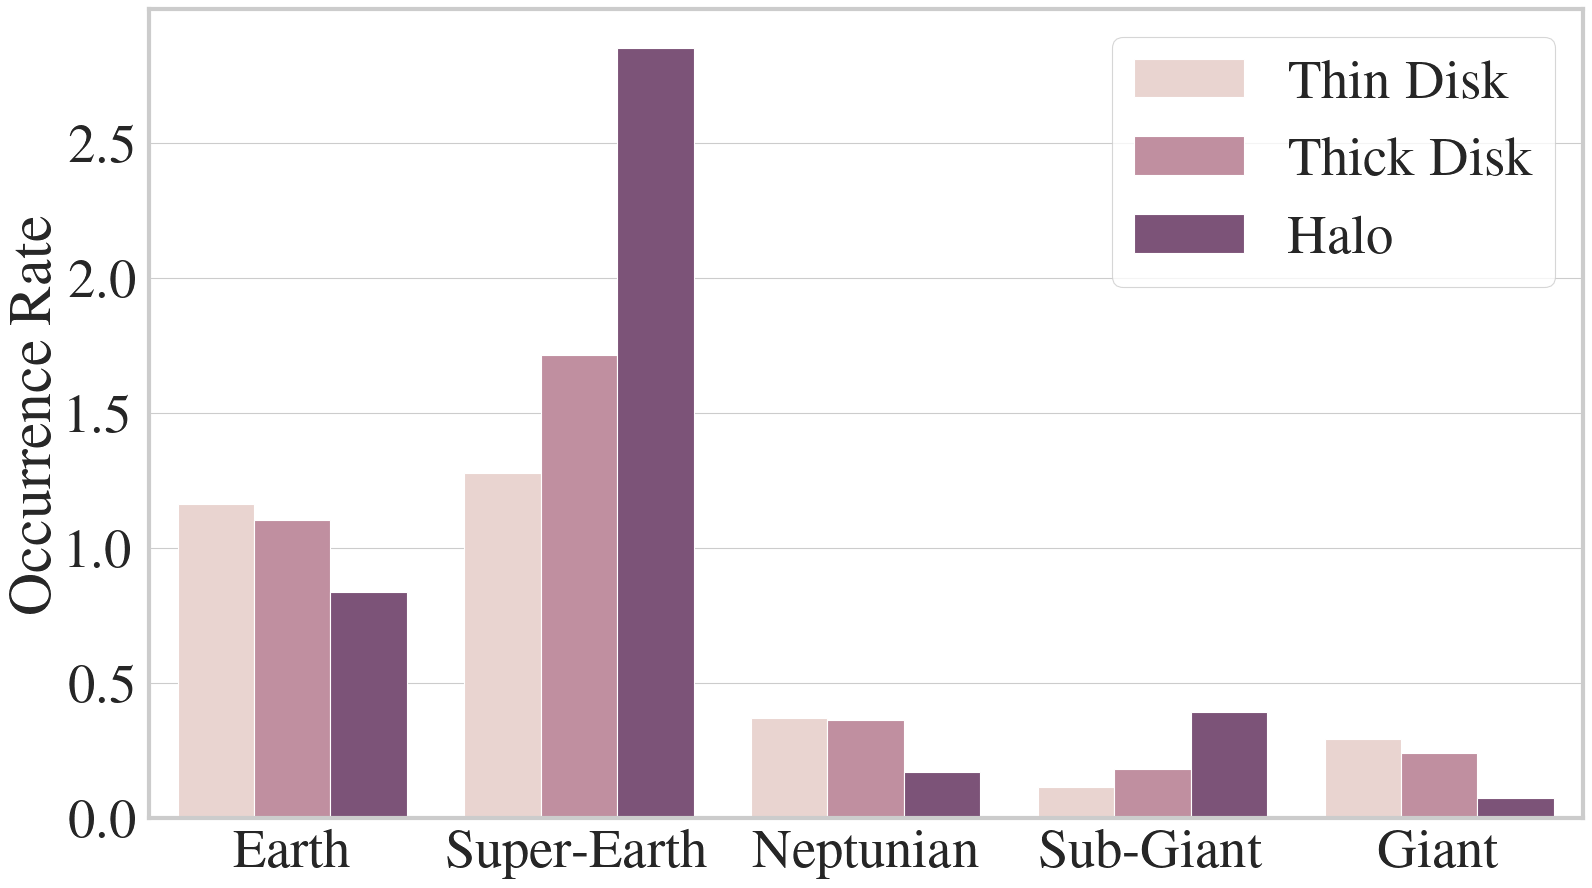

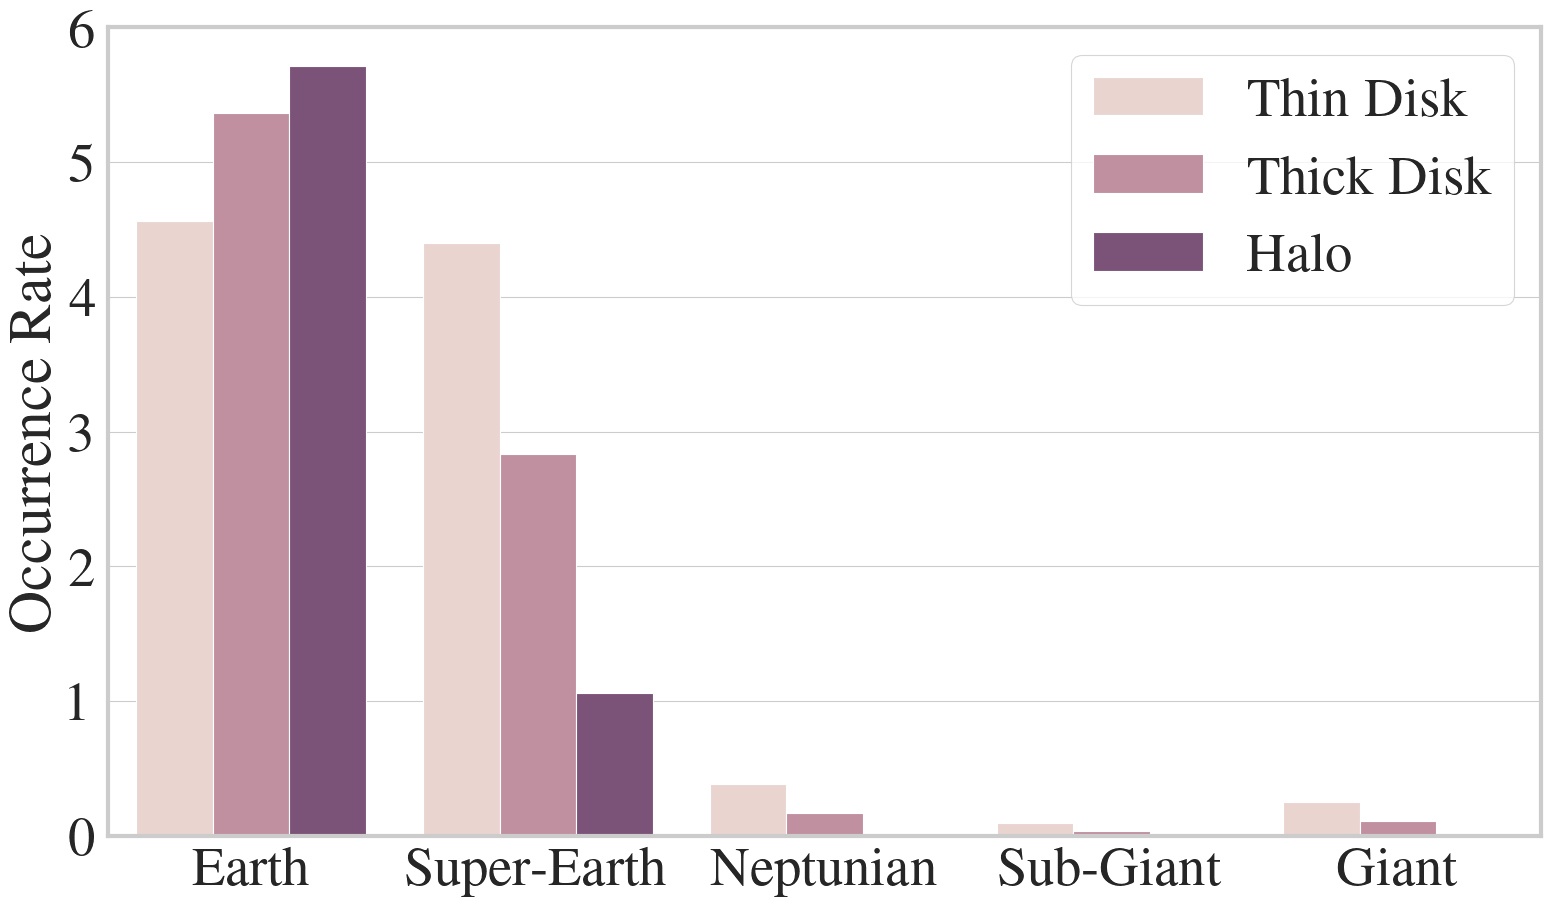

In [14]:
components = ["Thin Disk", "Thick Disk", "Halo"]

for num_embryos in [10, 100]:
    plt.figure()
    occurence_rates = metric_table[num_embryos]["Occurrence Rate"].reset_index()
    occurence_rates.rename(
        columns={"level_0": "Population", "level_1": "Planet Category"}, inplace=True
    )

    occurence_rate_barplot = sns.barplot(
        data=occurence_rates,
        x="Planet Category",
        y="Occurrence Rate",
        hue="Population",
        hue_order=components,
        palette=get_palette(n_colors=4),
    )
    occurence_rate_barplot.set_xlabel("")
    occurence_rate_barplot.legend(title="")

    FigureProcessor(occurence_rate_barplot.figure).save(
        f"occurence_rates_with_N_Embryos={num_embryos}.pdf",
        figure_directory=figure_directory,
        save=save,
    )